<a href="https://colab.research.google.com/github/rtegao/Pharma-Sales/blob/master/N02BE_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the EDA Notebook, I verified that the drug N02BE have the highest sales volume, so now, in this notebook, I'll try to predict the future sales from this specific drug.



# Libraries

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Importing

In [0]:
df_daily = pd.read_csv('/content/drive/My Drive/ML Projects/Pharma Sales/Data/salesdaily.csv')
# df_daily = df_daily[['datum','Weekday Name','N02BE']]
# df_daily.columns = ['data','weekday','N02BE']

df_daily = df_daily['N02BE']


# df_houly = pd.read_csv('/content/drive/My Drive/ML Projects/Pharma Sales/Data/saleshourly.csv')
# df_monthly = pd.read_csv('/content/drive/My Drive/ML Projects/Pharma Sales/Data/salesmonthly.csv')
# df_weekly = pd.read_csv('/content/drive/My Drive/ML Projects/Pharma Sales/Data/salesweekly.csv')

# Spliting Data

In [0]:
def dataSplit(df,train_percent,val_percent):
  train_limit = int(round((df.shape[0])*train_percent,0))
  val_limit = int(round((df.shape[0])*(train_percent+val_percent),0))
  
  df_train = df[:train_limit]
  df_val = df[train_limit:val_limit]
  df_test = df[val_limit:]

  print(df_train.shape)
  print(df_val.shape)
  print(df_test.shape)

  return df_train,df_val,df_test

In [0]:
df_train,df_val,df_test = dataSplit(df = df_daily,train_percent = 0.7,val_percent = 0.15)

(1474,)
(316,)
(316,)


# Normalizing Data

In [0]:
def normalizing_data(df_train,df_val,df_test):
  try:
    data_list = [df_train.copy(),df_val.copy(),df_test.copy()]
    min_list = df_train.min(axis=0)
    max_list = df_train.max(axis=0)
    for j in range(len(data_list)):
      for i in range(df_train.shape[1]):
        data_list[j].iloc[:,i] = (data_list[j].iloc[:,i]-min_list[i])/abs((min_list[i]-max_list[i]))
      data_list[j] = data_list[j].values
  except:
    df_train = df_train.values.reshape(-1,1)
    df_val = df_val.values.reshape(-1,1)
    df_test = df_test.values.reshape(-1,1)

    data_list = [df_train.copy(),df_val.copy(),df_test.copy()]
    min_list = df_train.min(axis=0)
    max_list = df_train.max(axis=0)
    for j in range(3):
      for i in range(df_train.shape[1]):
        data_list[j][:,i] = (data_list[j][:,i]-min_list[i])/abs((min_list[i]-max_list[i]))

  df_train_norm = data_list[0].copy()
  df_val_norm = data_list[1].copy()
  df_test_norm = data_list[2].copy()

  print(df_train_norm.max(axis=0))
  print(df_train_norm.min(axis=0))
  print('\n')

  print(df_val_norm.max(axis=0))
  print(df_val_norm.min(axis=0))
  print('\n')

  print(df_test_norm.max(axis=0))
  print(df_test_norm.min(axis=0))

  print('-------------------------')

  print(df_train_norm.shape)
  print(df_val_norm.shape)
  print(df_test_norm.shape)
  return df_train_norm,df_val_norm,df_test_norm

In [0]:
df_train_norm,df_val_norm,df_test_norm = normalizing_data(df_train,df_val,df_test)

[1.]
[0.]


[0.46335404]
[0.]


[0.62173913]
[0.]
-------------------------
(1474, 1)
(316, 1)
(316, 1)


# Preprocessing

In [0]:
def Regressor(future_steps,time_steps,n_features,df_train,df_val,df_test):
  # future_steps: how many days in the furure to predict 
  # time_steps: number of samples the LSTM model will use for predict 28 days in the future
  # n_features: number of features (LSTM input) 

  #################### TRAIN #################################################
  # Defining the number of samples for the train data
  n_samples = df_train.shape[0]
  x_train = []
  y_train = []

  # shaping data to have the number of time_steps in the x_train ans the 28 future values in the y_train 
  for i in range(time_steps,n_samples - time_steps): 
    x_train.append(df_train[i - time_steps : i, :]) 
    y_train.append(df_train[i : i+future_steps,-1]) 

  x_train,y_train = np.array(x_train),np.array(y_train) # transforming in array
  # LSTM need 3D tensor as input 
  x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],n_features))  

  ##################### VALIDATION ###############################################

  df_val = np.concatenate((df_train[-time_steps:],df_val))

  n_samples = df_val.shape[0]
  x_val = []
  y_val = []

  for i in range(time_steps,n_samples - time_steps):
    x_val.append(df_val[i - time_steps : i, :]) 
    y_val.append(df_val[i : i+future_steps,-1]) 

  x_val,y_val = np.array(x_val),np.array(y_val)
  x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],n_features))

  ####################### TEST ################################################

  df_test = np.concatenate((df_val[-time_steps:],df_test))
  n_samples = df_test.shape[0]
  x_test = []
  y_test = []

  for i in range(time_steps,n_samples - time_steps):
    x_test.append(df_test[i - time_steps : i, :]) 
    y_test.append(df_test[i : i+future_steps,-1]) 

  x_test,y_test = np.array(x_test),np.array(y_test)
  x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],n_features))

  x_train = x_train.astype(np.float32)
  y_train = y_train.astype(np.float32)

  x_val = x_val.astype(np.float32)
  y_val = y_val.astype(np.float32)

  x_test = x_test.astype(np.float32)
  y_test = y_test.astype(np.float32)
  
  return x_train,x_test,x_val,y_train,y_val,y_test

In [0]:
time_steps = 60
future_steps = 5
n_features = df_train_norm.shape[1]
x_train,x_test,x_val,y_train,y_val,y_test = Regressor(future_steps = future_steps,time_steps = time_steps,n_features = n_features,df_train = df_train_norm,df_val = df_val_norm,df_test = df_test_norm)

# LSTM

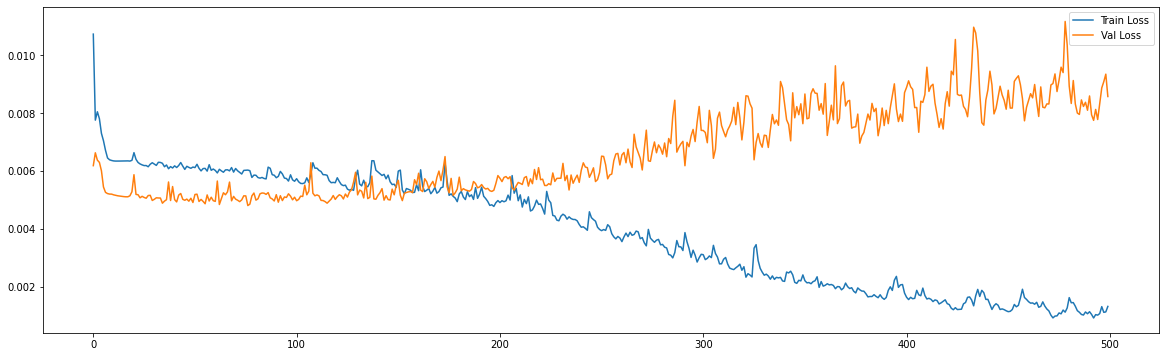

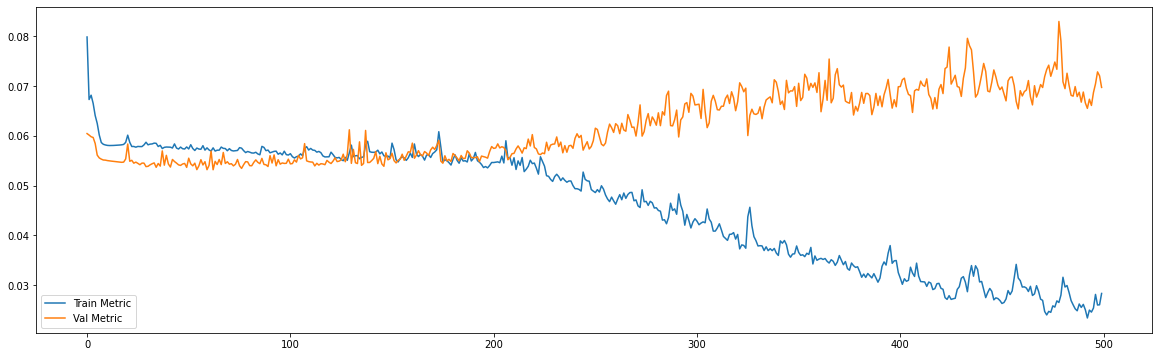



43/43 [==============================] - 0s 3ms/step - loss: 0.0014 - mae: 0.0288
loss and metric train data [0.001382043119519949, 0.02879319153726101]
8/8 [==============================] - 0s 3ms/step - loss: 0.0086 - mae: 0.0697
loss and metric val data [0.008569181896746159, 0.06973050534725189]
8/8 [==============================] - 0s 2ms/step - loss: 0.0106 - mae: 0.0780
loss and metric test data [0.010622327215969563, 0.07796012610197067]


In [0]:
del regressor
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
# mom = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
# sgd = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

# early stop
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 500, batch_size=60, verbose = 0, shuffle= False
                        # , callbacks=[es]
                        )

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

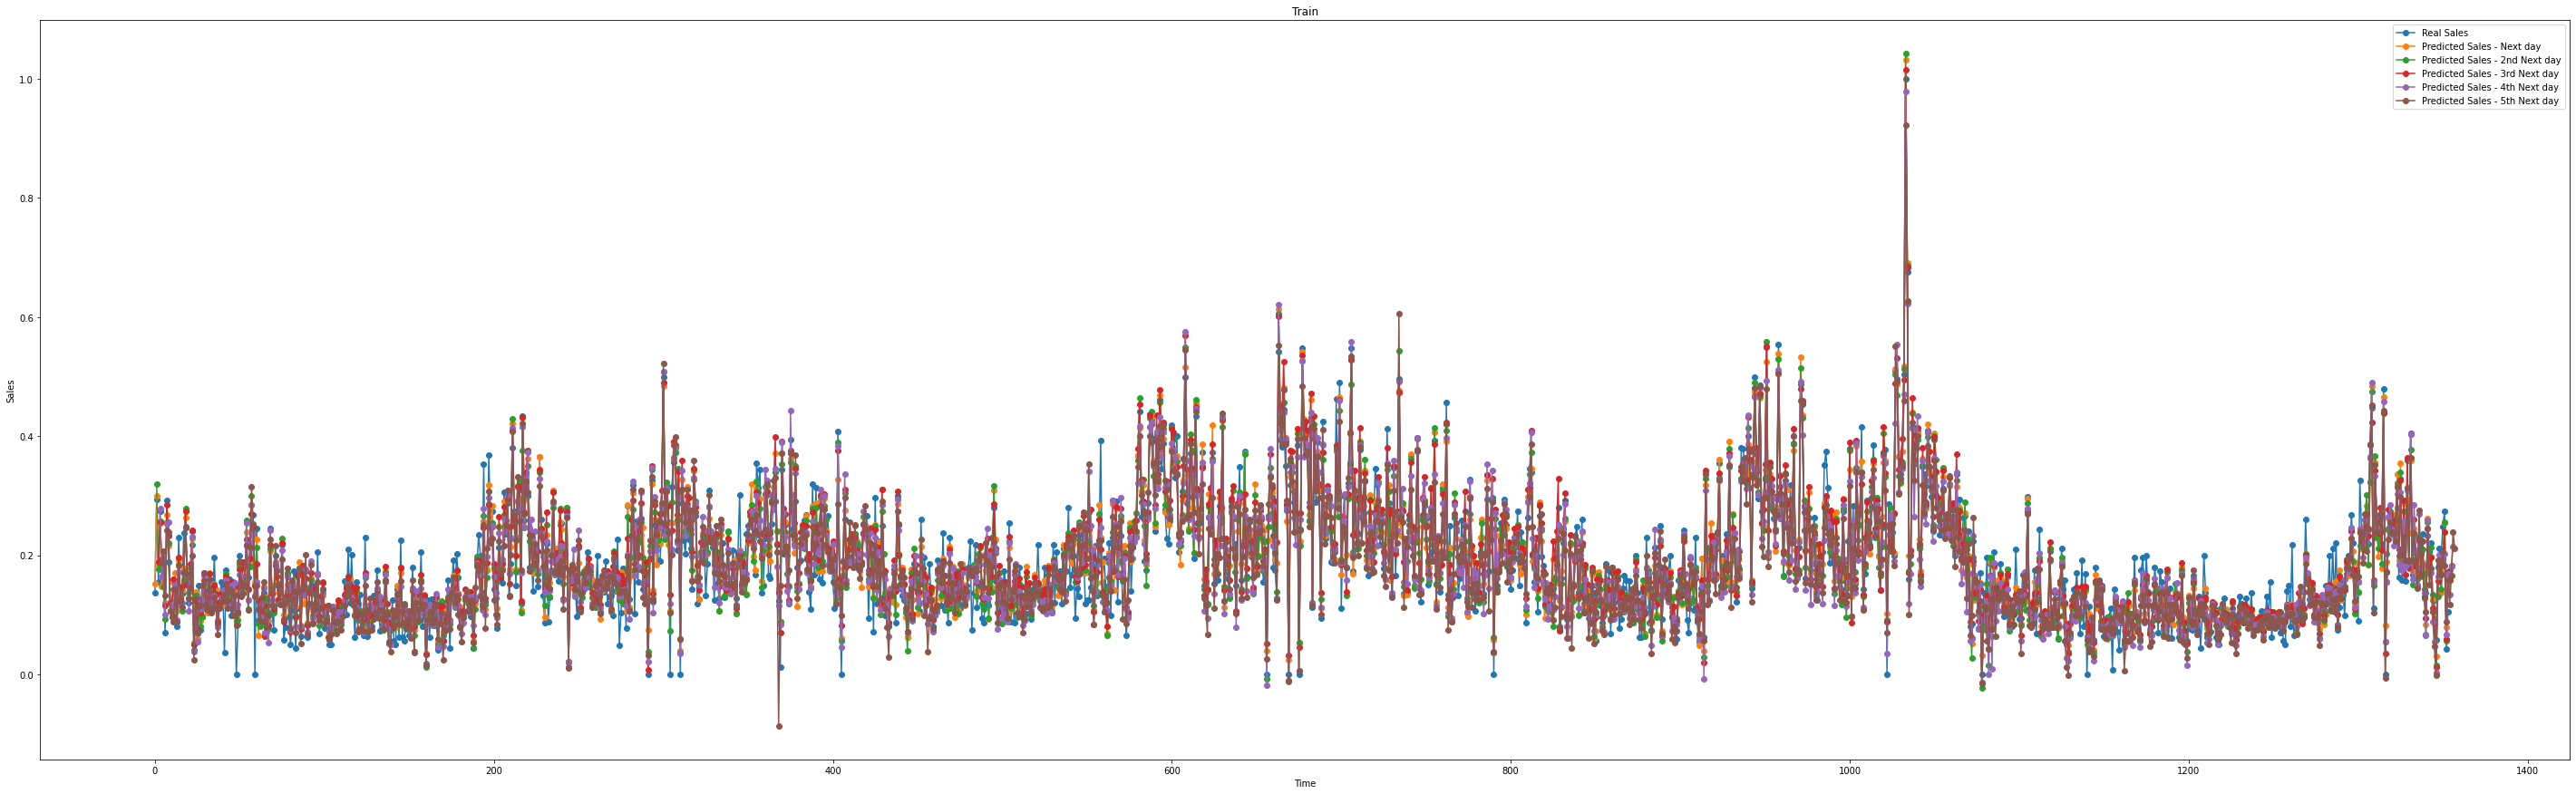

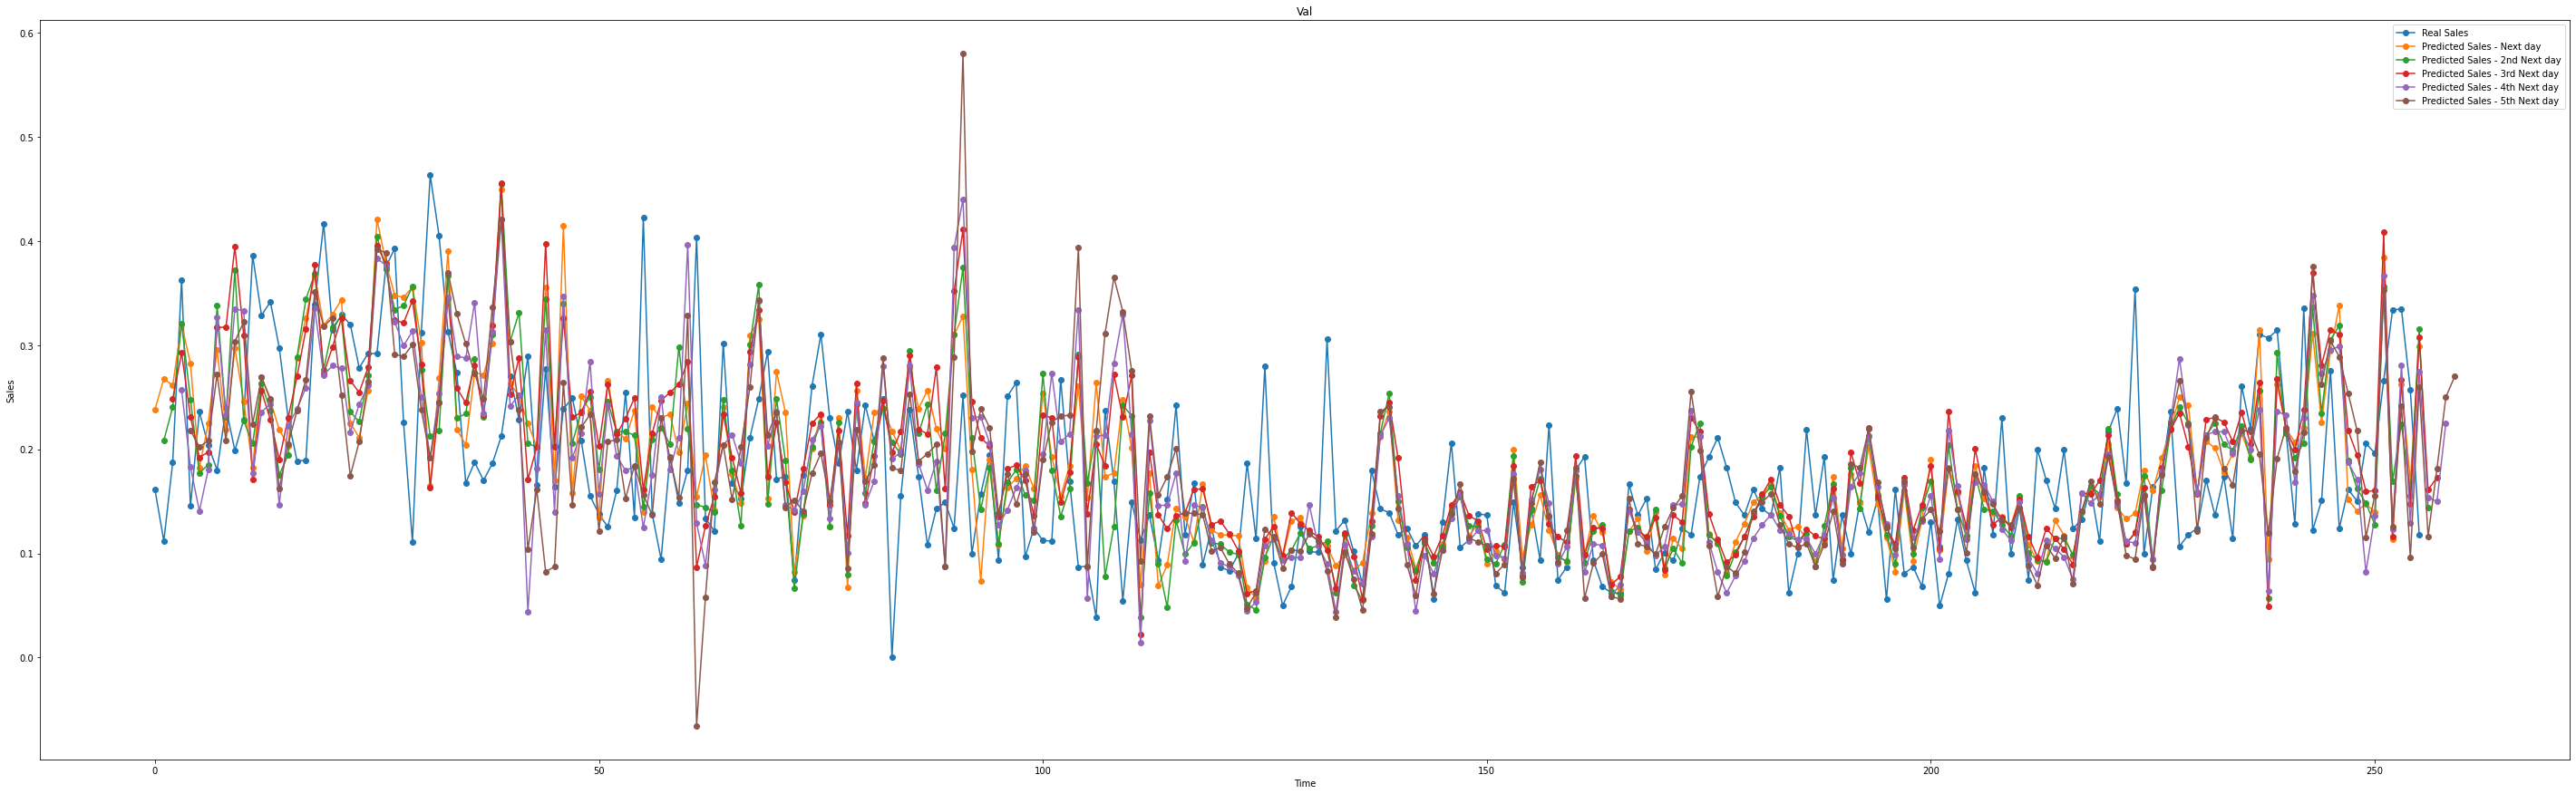

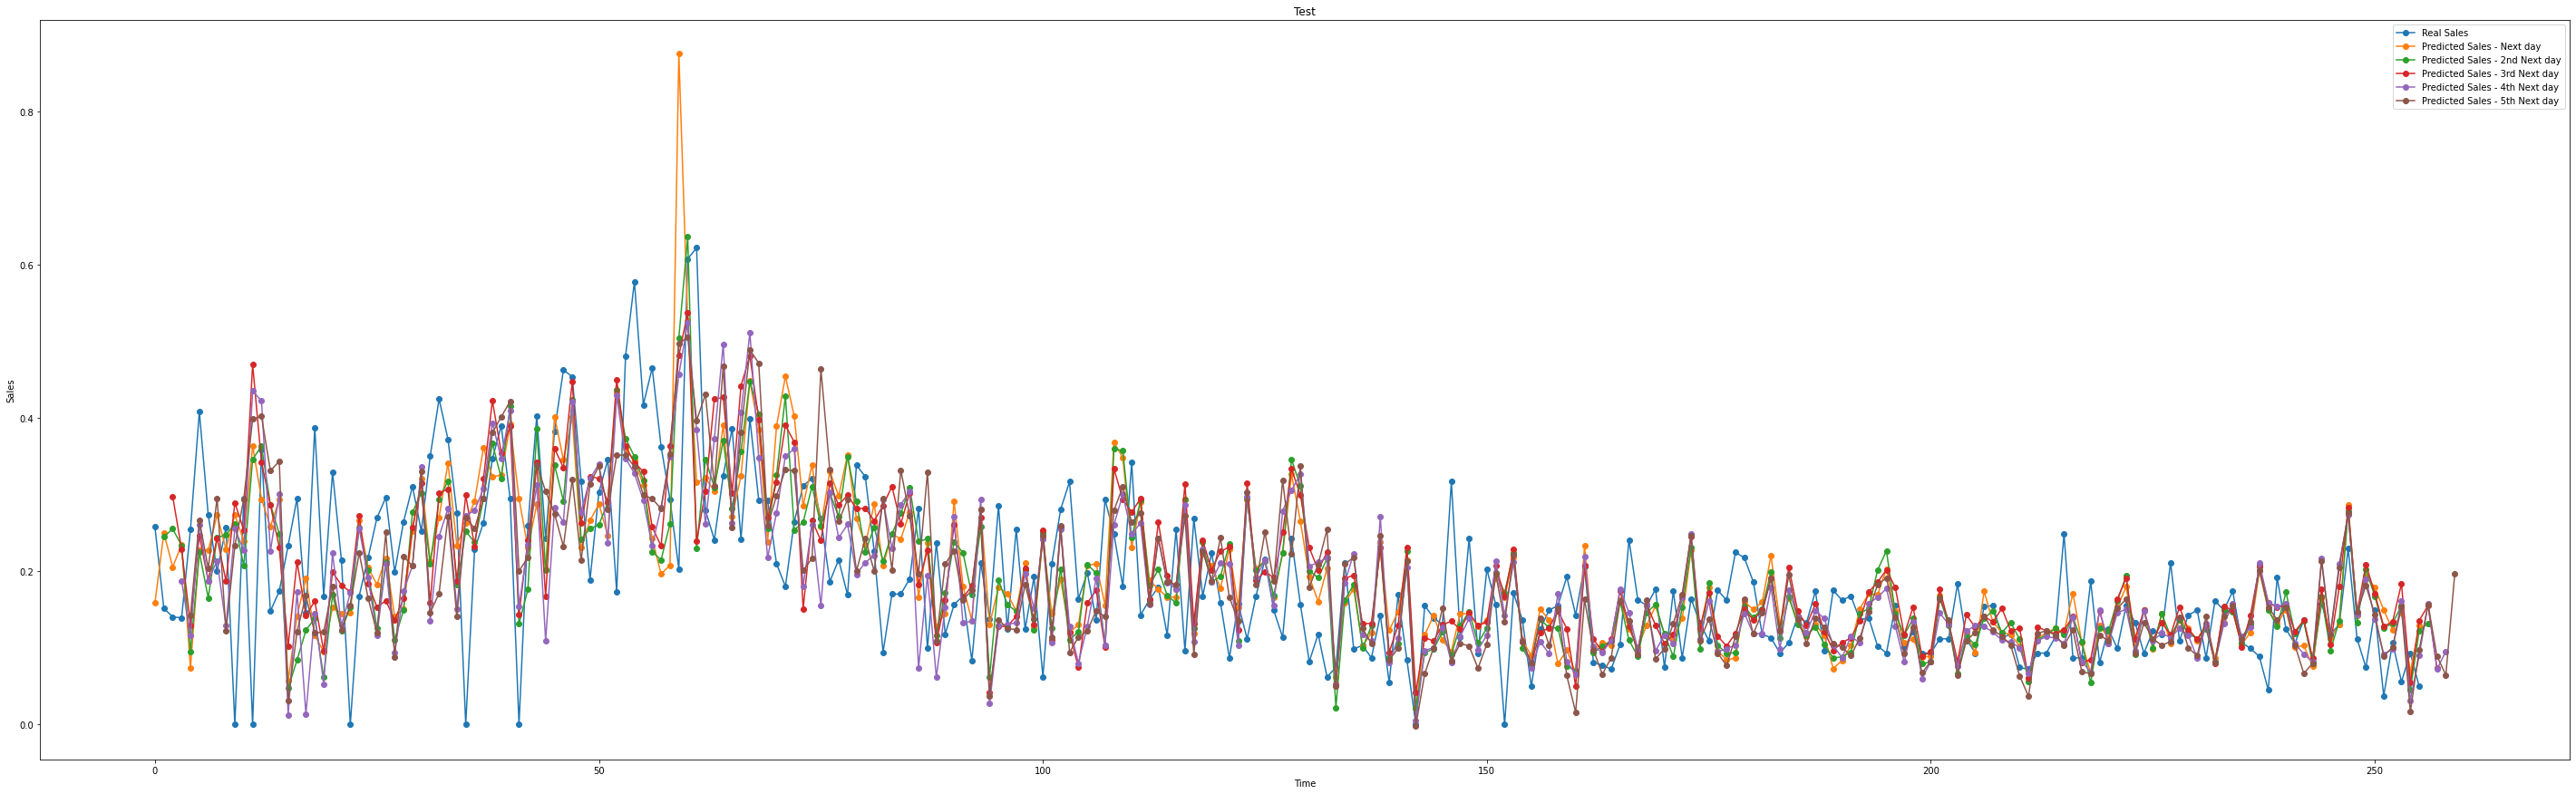

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train[:,0],marker='o',label='Real Sales')
plt.plot(y_train_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_train_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_train_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_train_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_train_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Train')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val[:,0],marker='o',label='Real Sales')
plt.plot(y_val_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_val_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_val_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_val_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_val_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Val')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_test[:,0],marker='o',label='Real Sales')
plt.plot(y_test_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_test_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_test_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_test_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_test_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

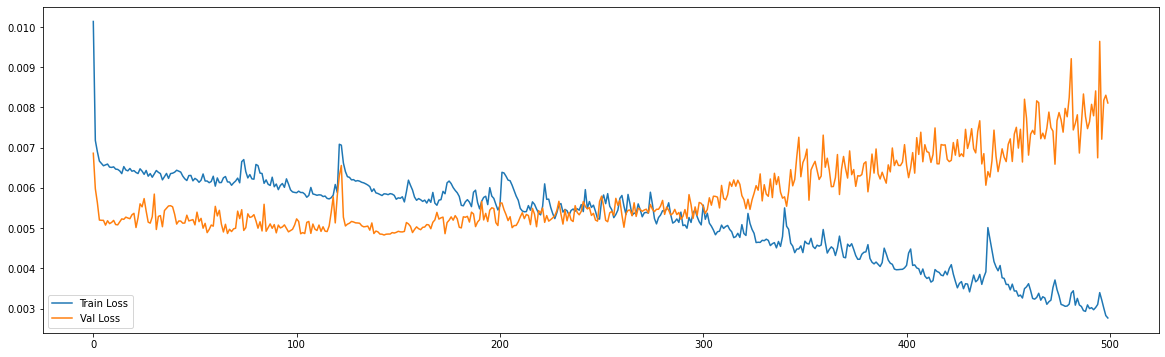

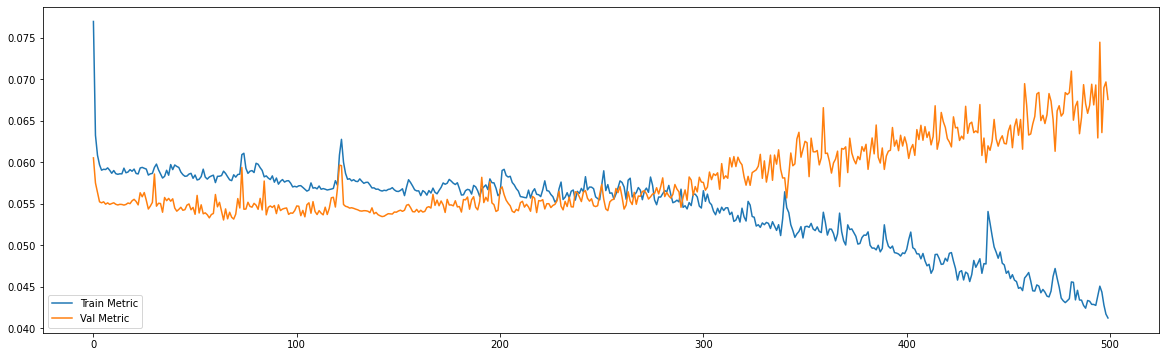



43/43 [==============================] - 0s 3ms/step - loss: 0.0024 - mae: 0.0384
loss and metric train data [0.0024107780773192644, 0.03838658332824707]
8/8 [==============================] - 0s 3ms/step - loss: 0.0081 - mae: 0.0676
loss and metric val data [0.008111055940389633, 0.06758446246385574]
8/8 [==============================] - 0s 2ms/step - loss: 0.0088 - mae: 0.0687
loss and metric test data [0.008823028765618801, 0.06867588311433792]


In [0]:
del regressor
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dropout(0.2))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
# mom = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
# sgd = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

# early stop
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 500, batch_size=60, verbose = 0, shuffle= False
                        # , callbacks=[es]
                        )

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

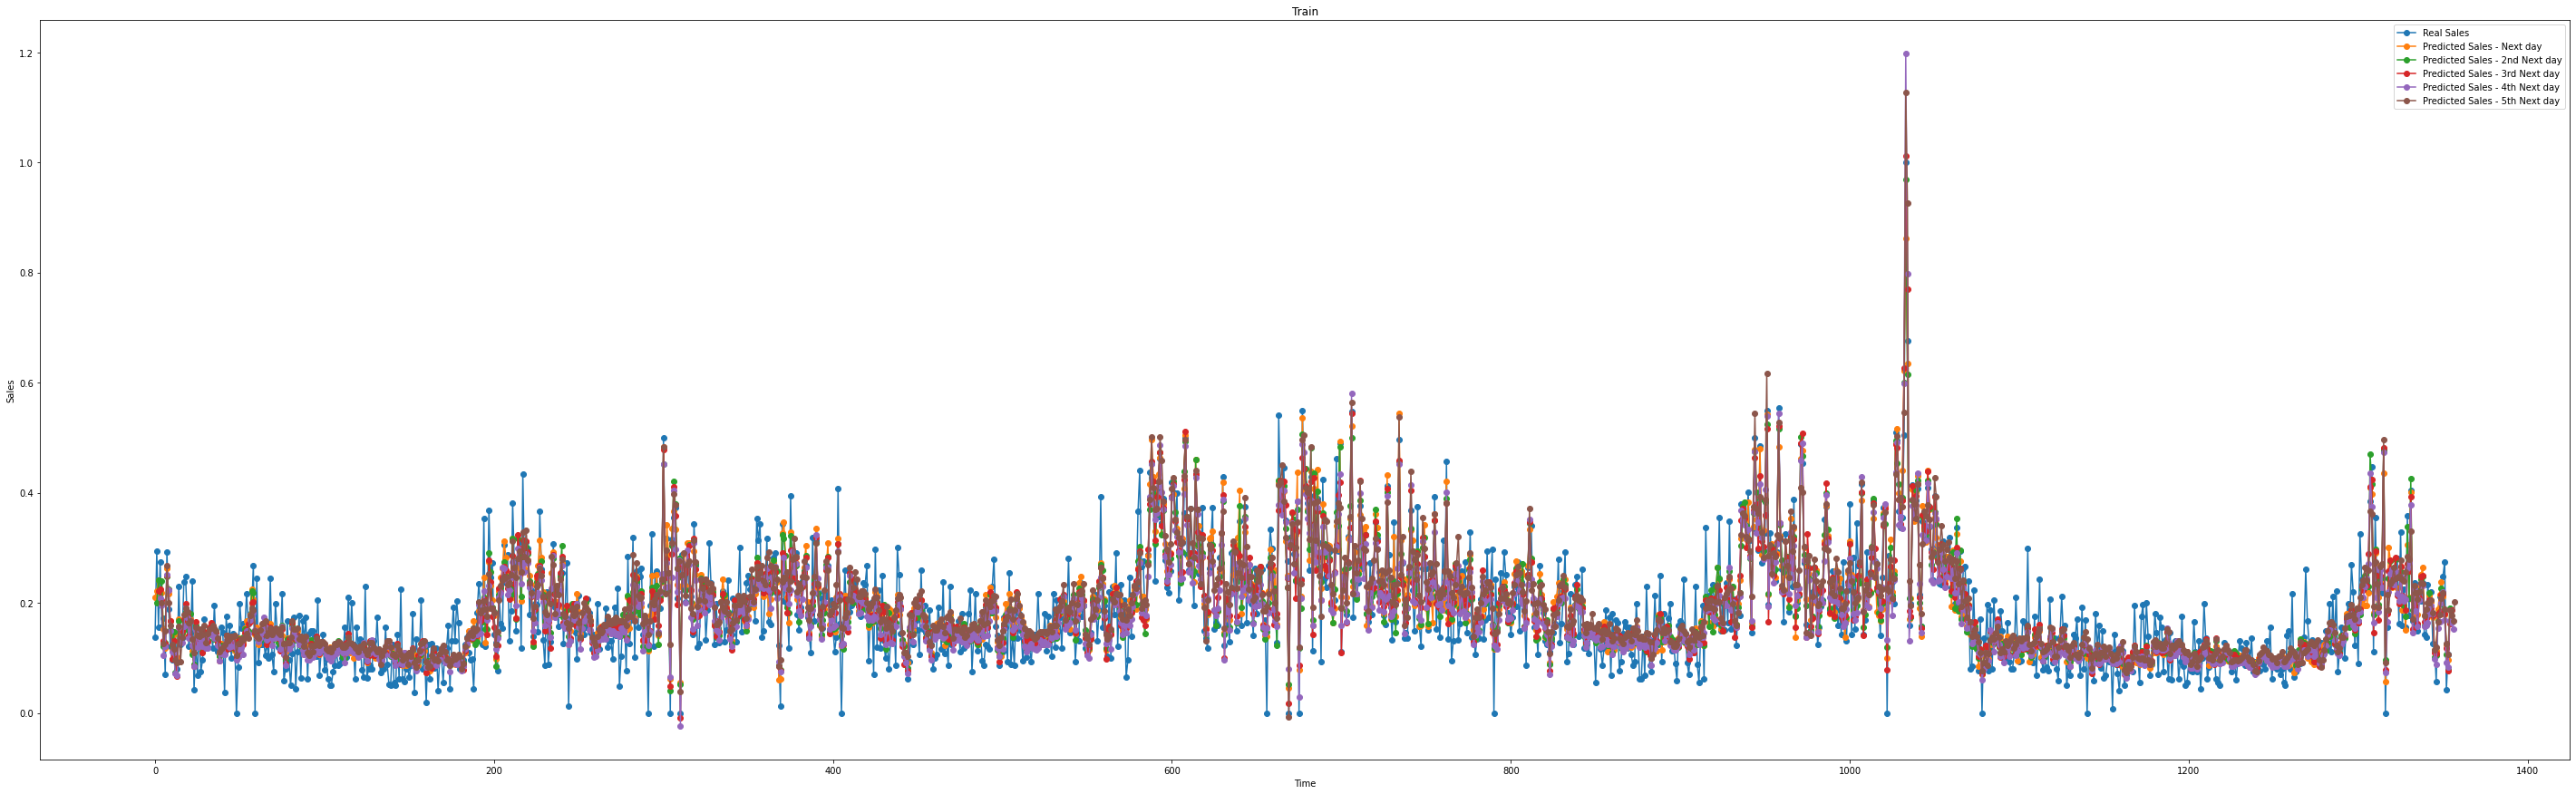

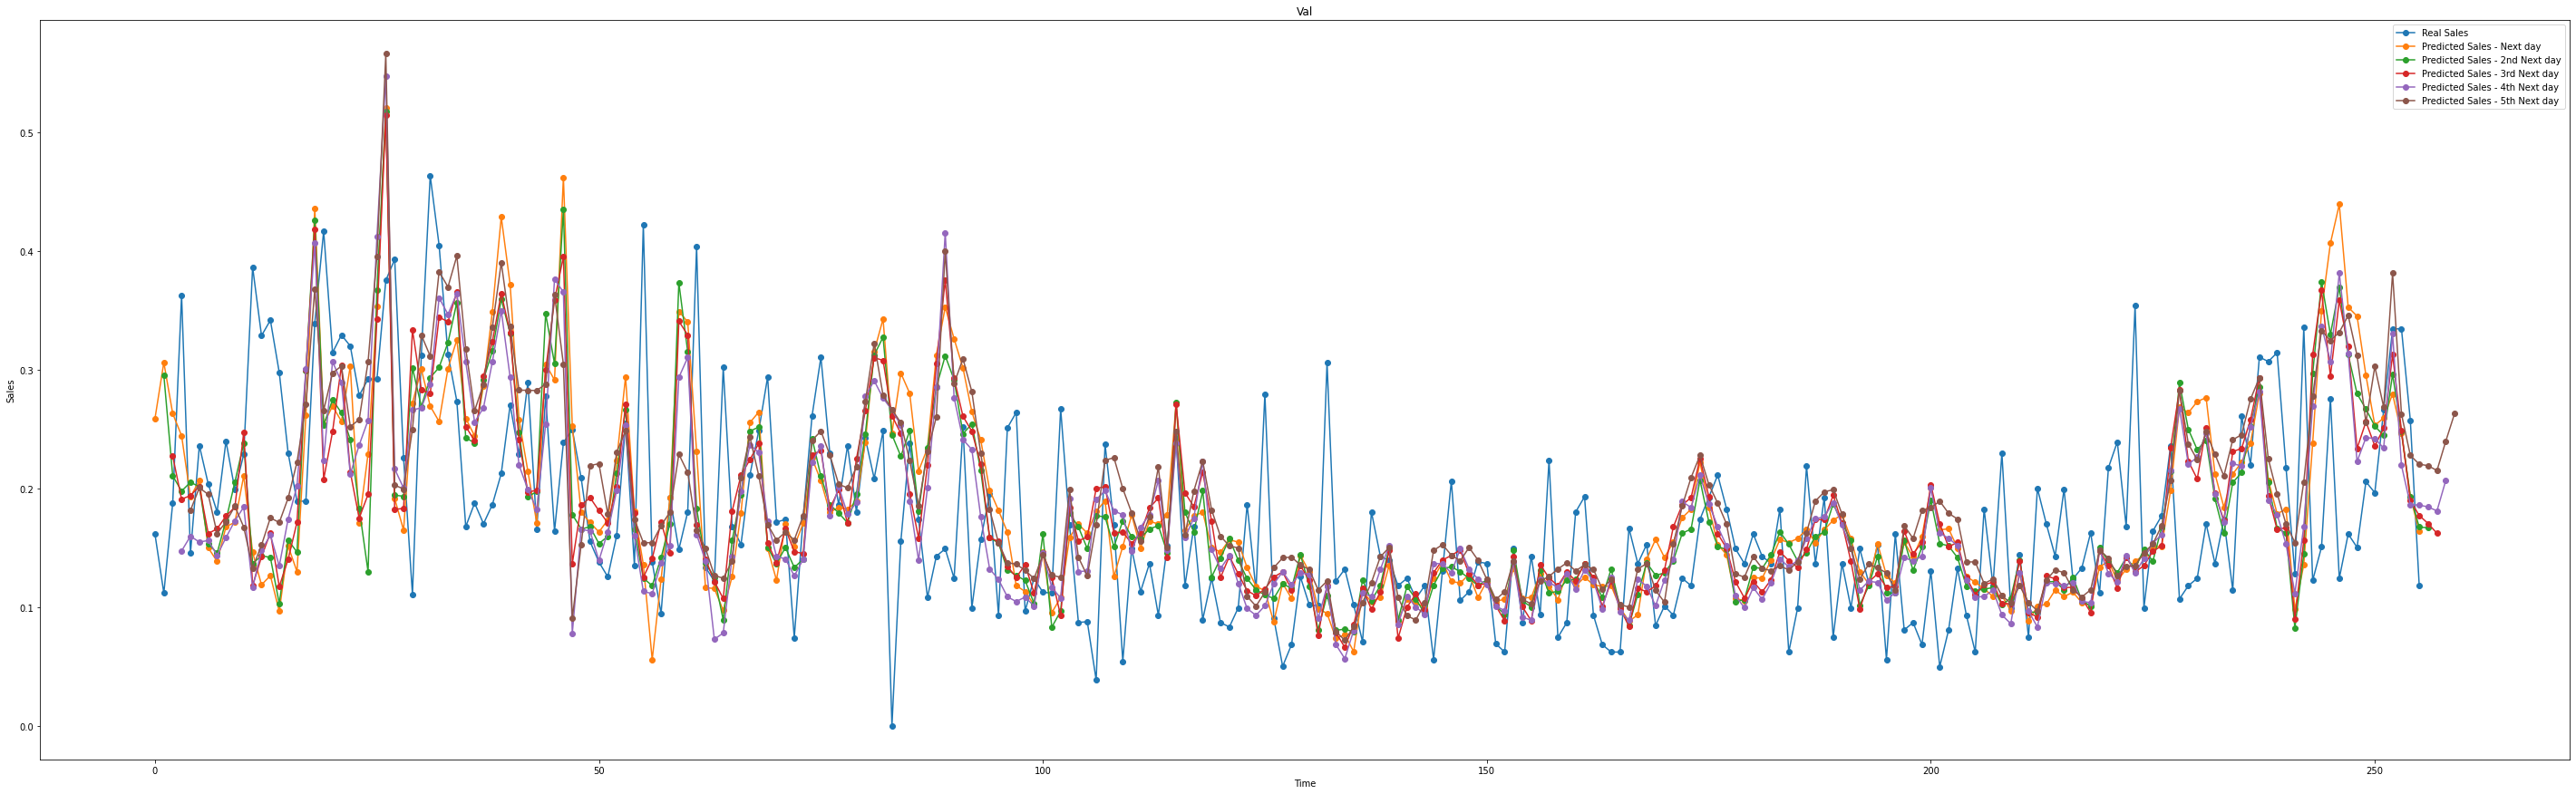

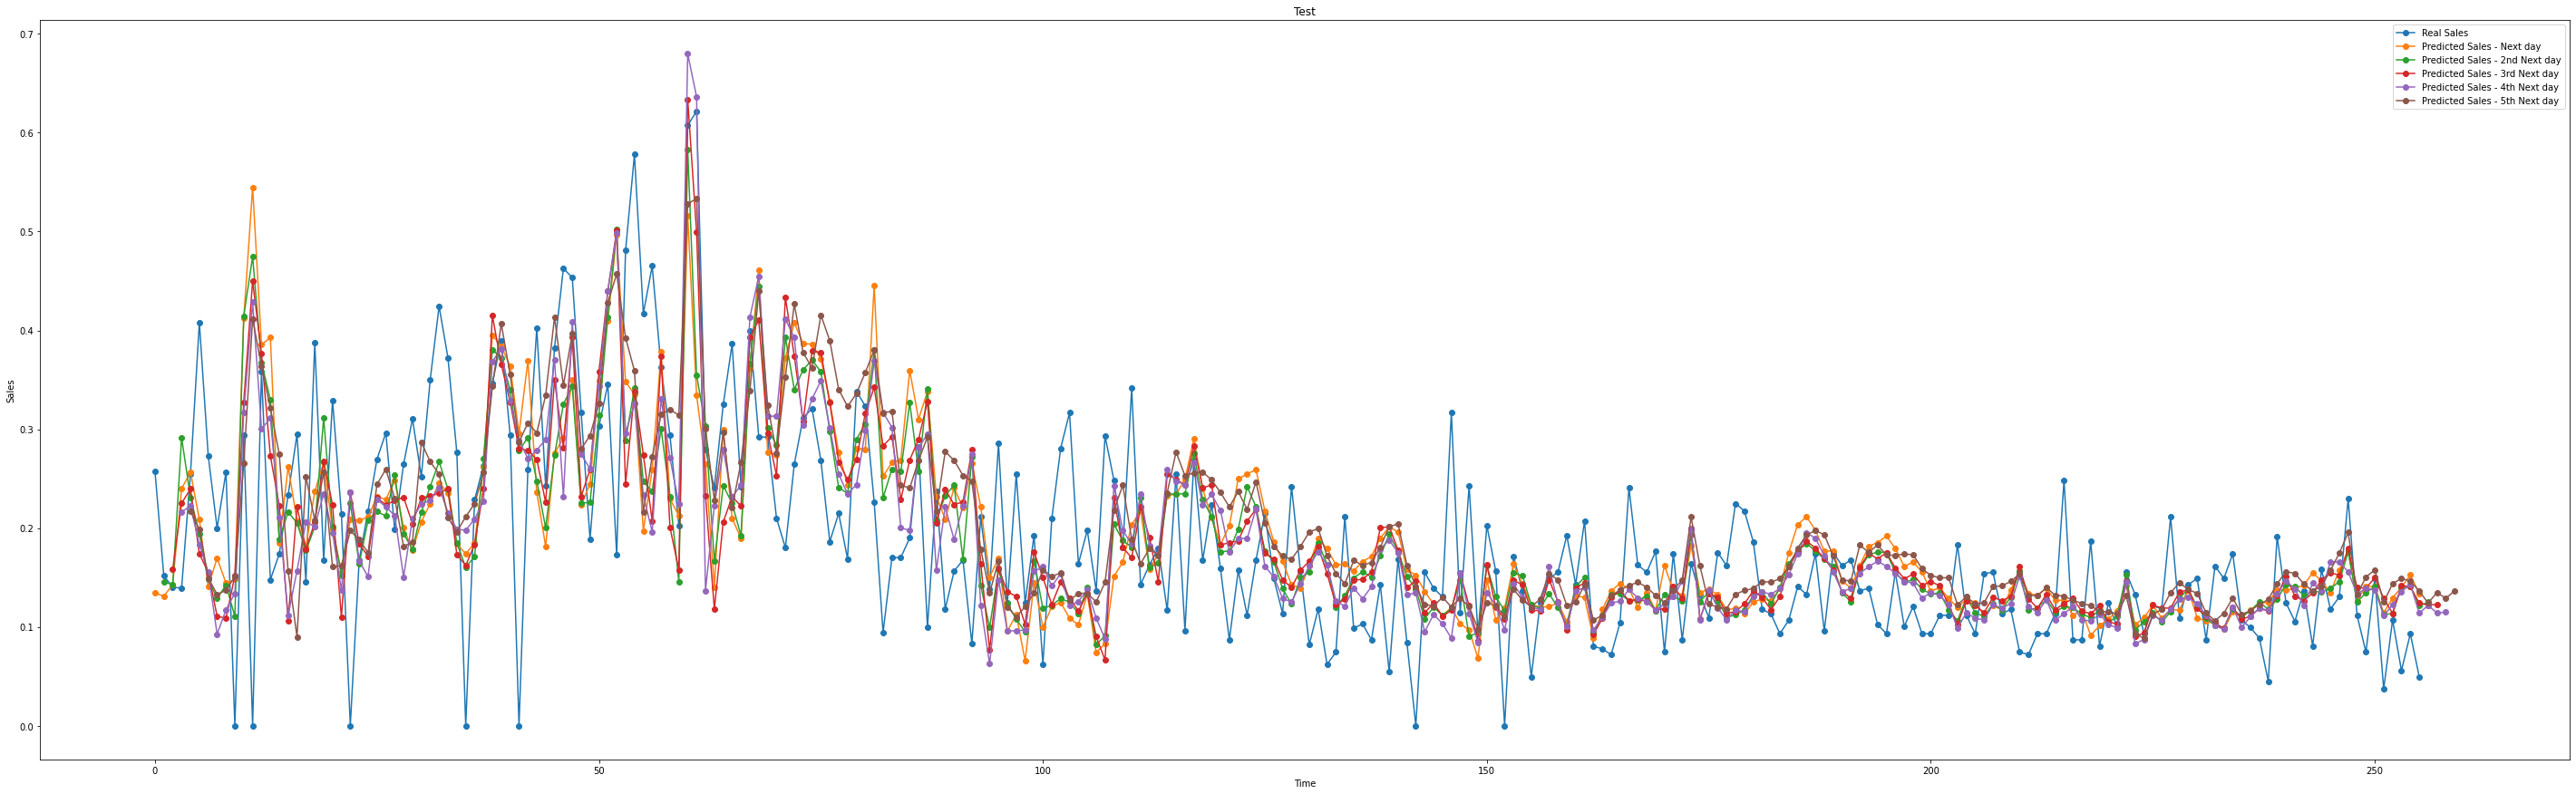

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train[:,0],marker='o',label='Real Sales')
plt.plot(y_train_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_train_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_train_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_train_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_train_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Train')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val[:,0],marker='o',label='Real Sales')
plt.plot(y_val_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_val_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_val_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_val_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_val_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Val')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_test[:,0],marker='o',label='Real Sales')
plt.plot(y_test_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_test_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_test_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_test_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_test_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

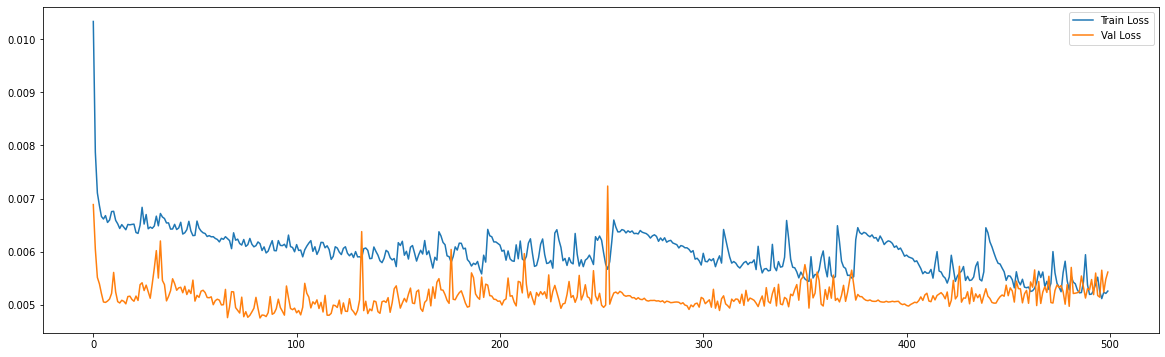

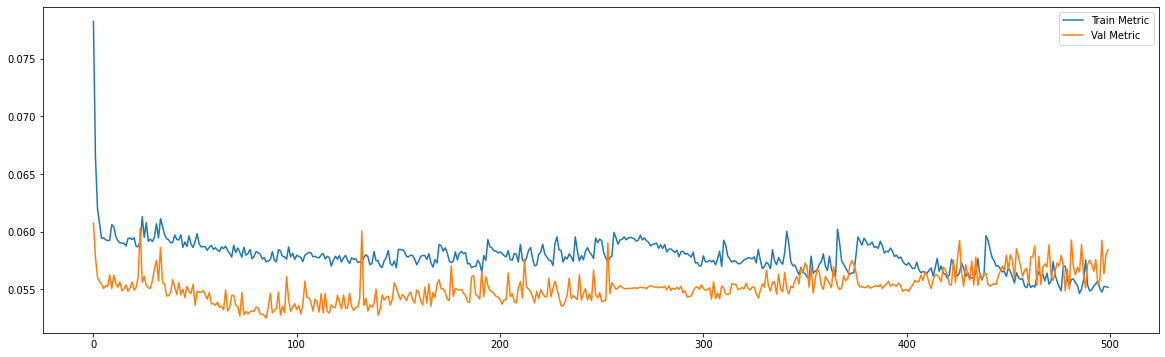



43/43 [==============================] - 0s 3ms/step - loss: 0.0051 - mae: 0.0533
loss and metric train data [0.0051467991434037685, 0.05329494923353195]
8/8 [==============================] - 0s 2ms/step - loss: 0.0056 - mae: 0.0584
loss and metric val data [0.005612438544631004, 0.05842066556215286]
8/8 [==============================] - 0s 2ms/step - loss: 0.0080 - mae: 0.0642
loss and metric test data [0.007978078909218311, 0.06424269080162048]


In [0]:
del regressor
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=False, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dropout(0.4))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
# mom = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
adam = optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
# sgd = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

# early stop
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 500, batch_size=60, verbose = 0, shuffle= False
                        # , callbacks=[es]
                        )

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

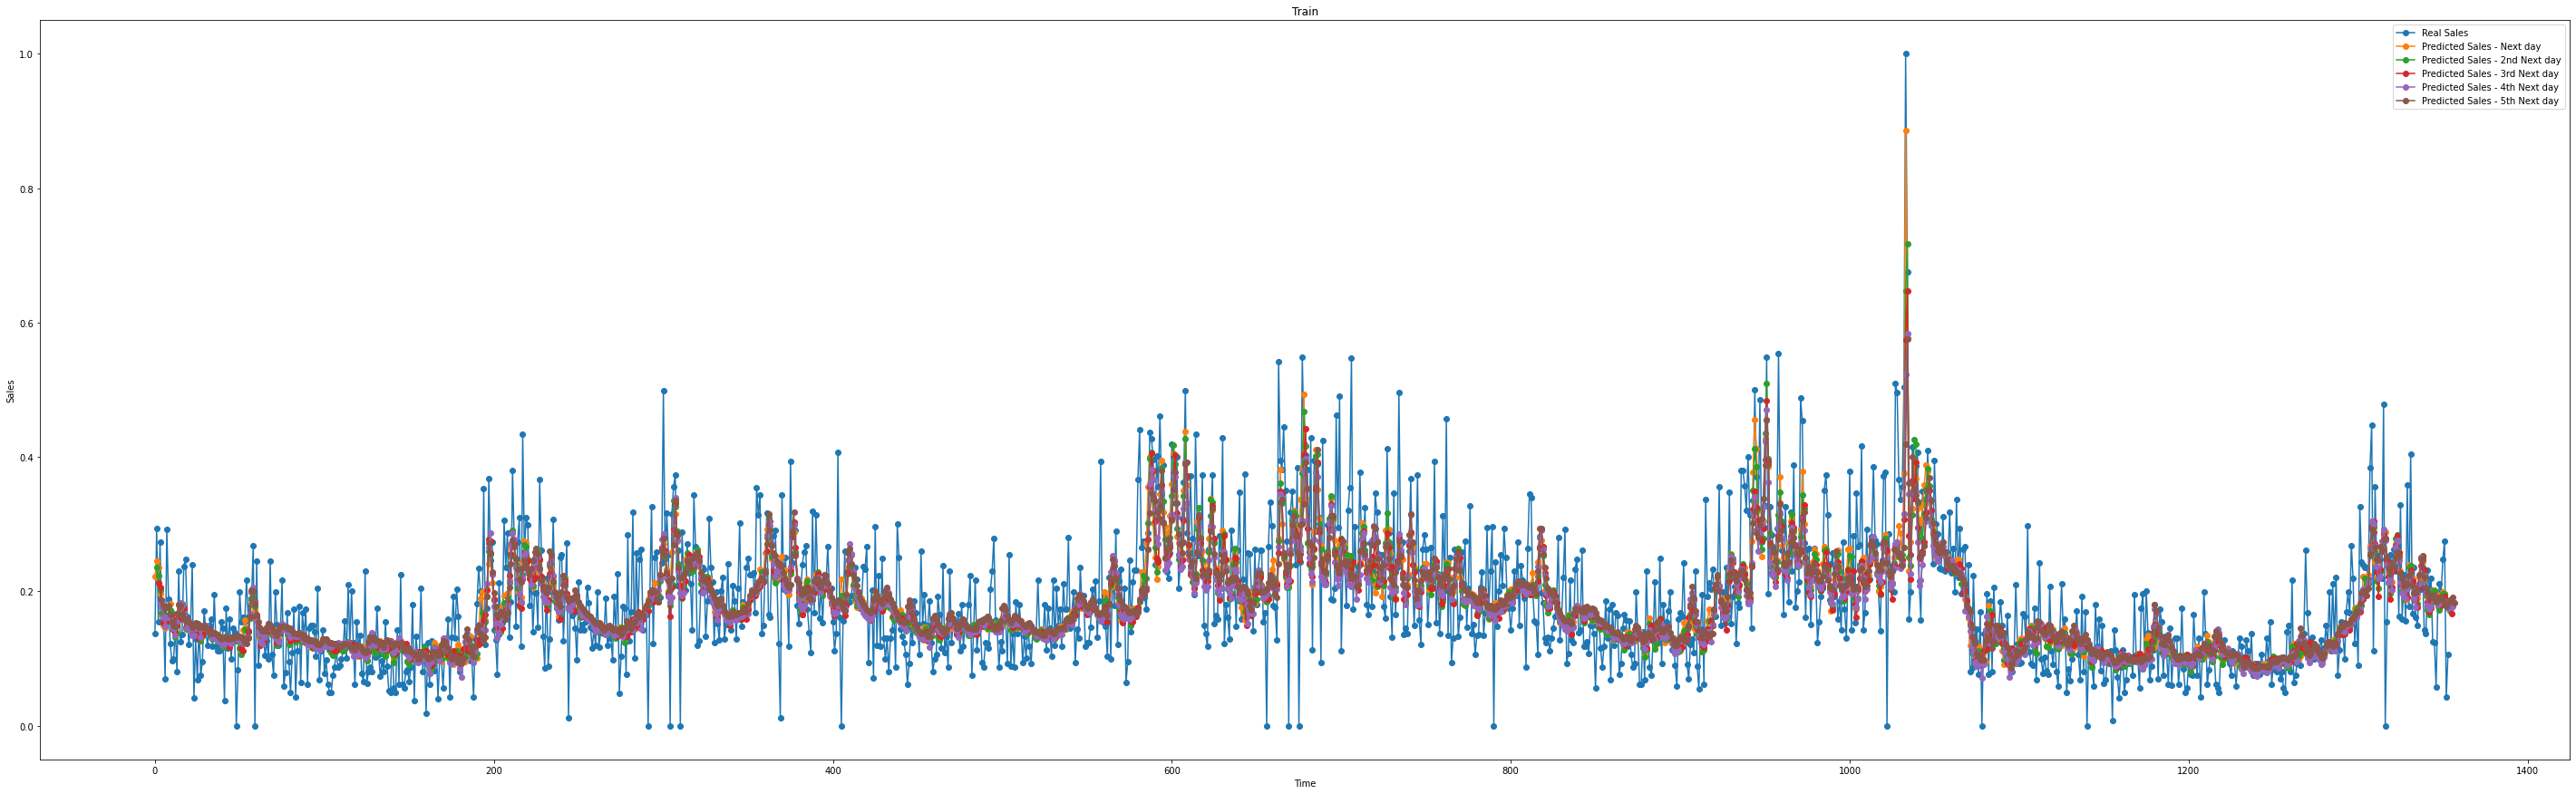

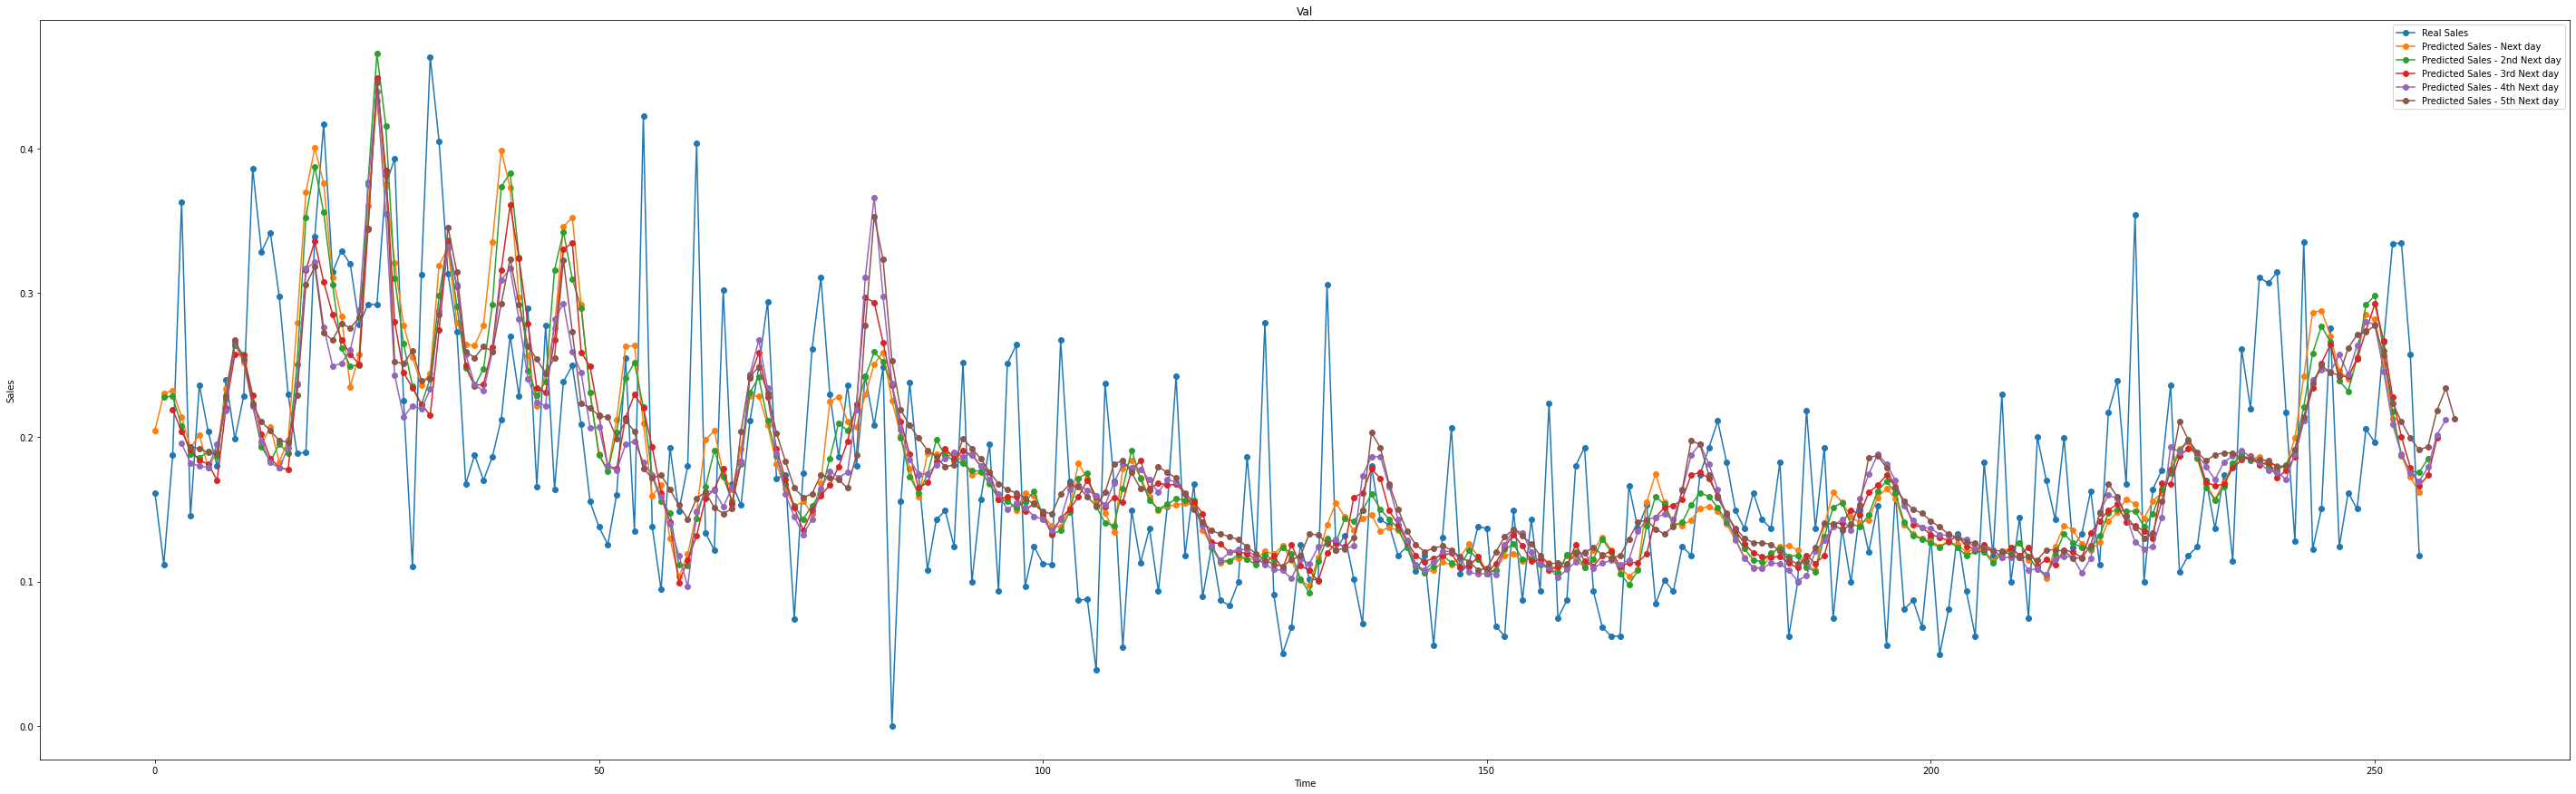

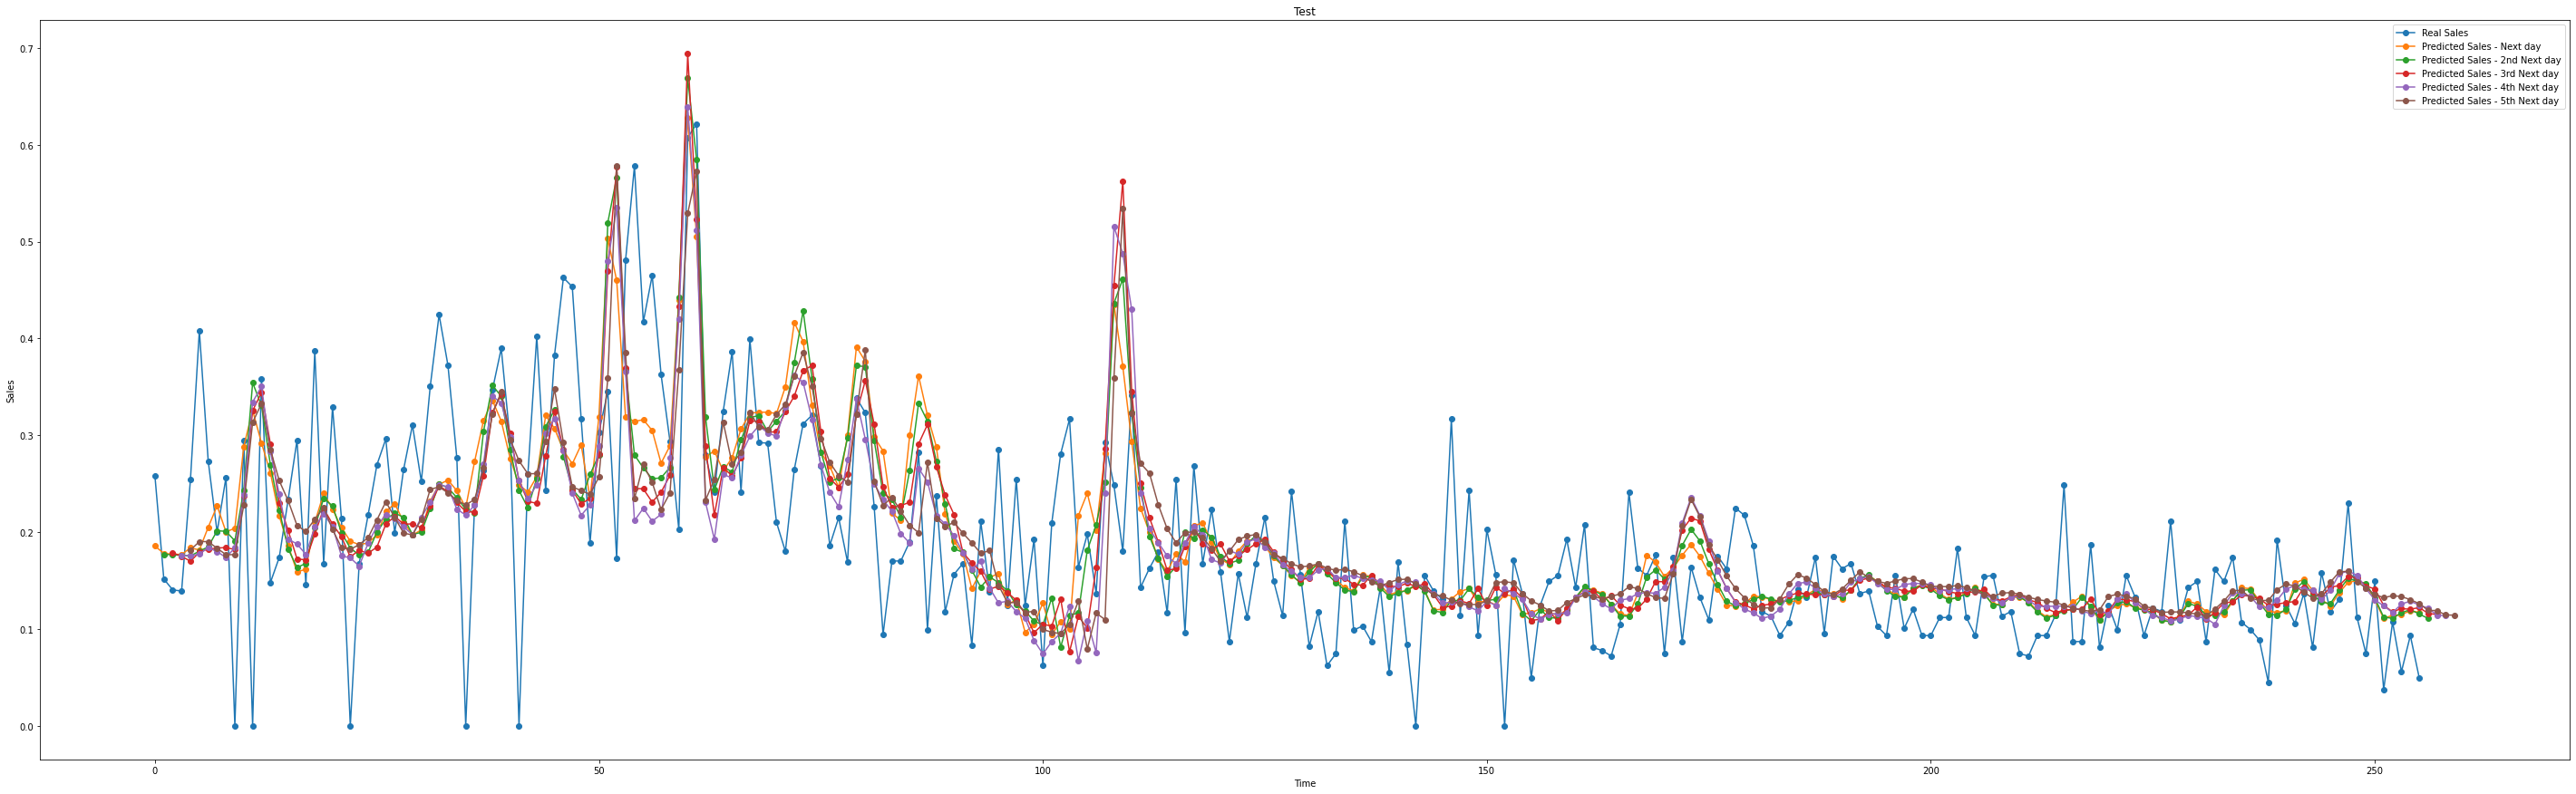

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train[:,0],marker='o',label='Real Sales')
plt.plot(y_train_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_train_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_train_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_train_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_train_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Train')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val[:,0],marker='o',label='Real Sales')
plt.plot(y_val_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_val_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_val_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_val_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_val_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Val')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_test[:,0],marker='o',label='Real Sales')
plt.plot(y_test_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_test_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_test_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_test_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_test_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

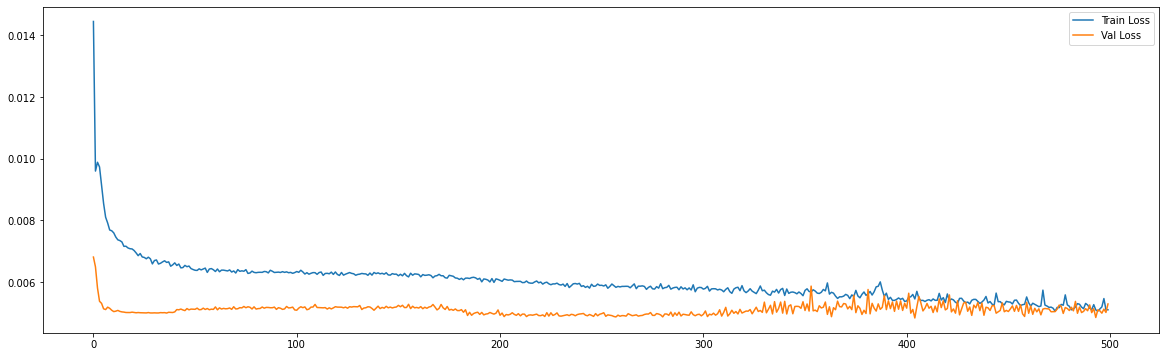

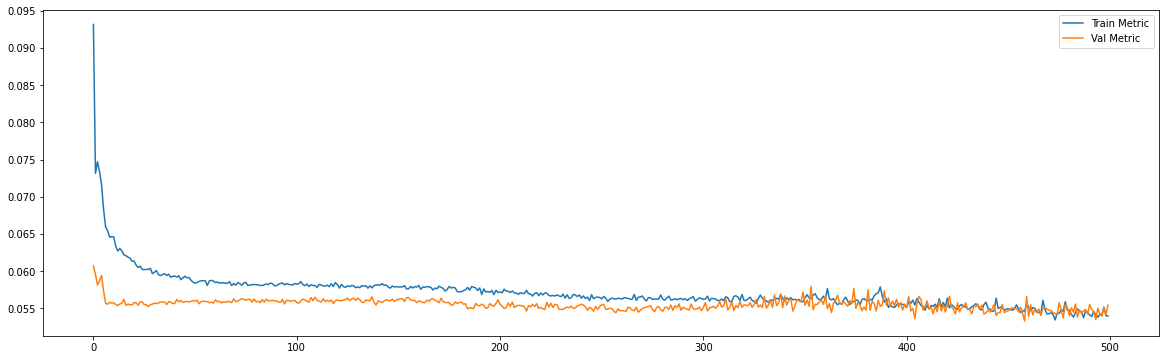



43/43 [==============================] - 0s 4ms/step - loss: 0.0047 - mae: 0.0520
loss and metric train data [0.004713291767984629, 0.05199124664068222]
8/8 [==============================] - 0s 4ms/step - loss: 0.0053 - mae: 0.0554
loss and metric val data [0.005286149214953184, 0.0554286390542984]
8/8 [==============================] - 0s 3ms/step - loss: 0.0083 - mae: 0.0661
loss and metric test data [0.008342788554728031, 0.06610136479139328]


In [0]:
del regressor
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, n_features))) # return_sequences=False next layer is not LSTM
regressor.add(Dropout(0.4))
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.4))
regressor.add(Dense(units=future_steps))

#Compiling the LSTM
# mom = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
adam = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, decay = 0.0)
# sgd = optimizers.SGD(lr=0.01, decay=1e-02, momentum=0.9,nesterov=True)
regressor.compile(optimizer = adam, loss = 'mse', metrics=['mae'])

# early stop
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#Fitting to traning set
history = regressor.fit(x_train, y_train, validation_data=(x_val,y_val), epochs = 500, batch_size=60, verbose = 0, shuffle= False
                        # , callbacks=[es]
                        )

plt.figure(figsize=(20,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train Loss', 'Val Loss'])

plt.figure(figsize=(20,6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.legend(['Train Metric', 'Val Metric'])
plt.show()

print('\n')
print('loss and metric train data',regressor.evaluate(x_train,y_train))
print('loss and metric val data',regressor.evaluate(x_val,y_val))
print('loss and metric test data',regressor.evaluate(x_test,y_test))

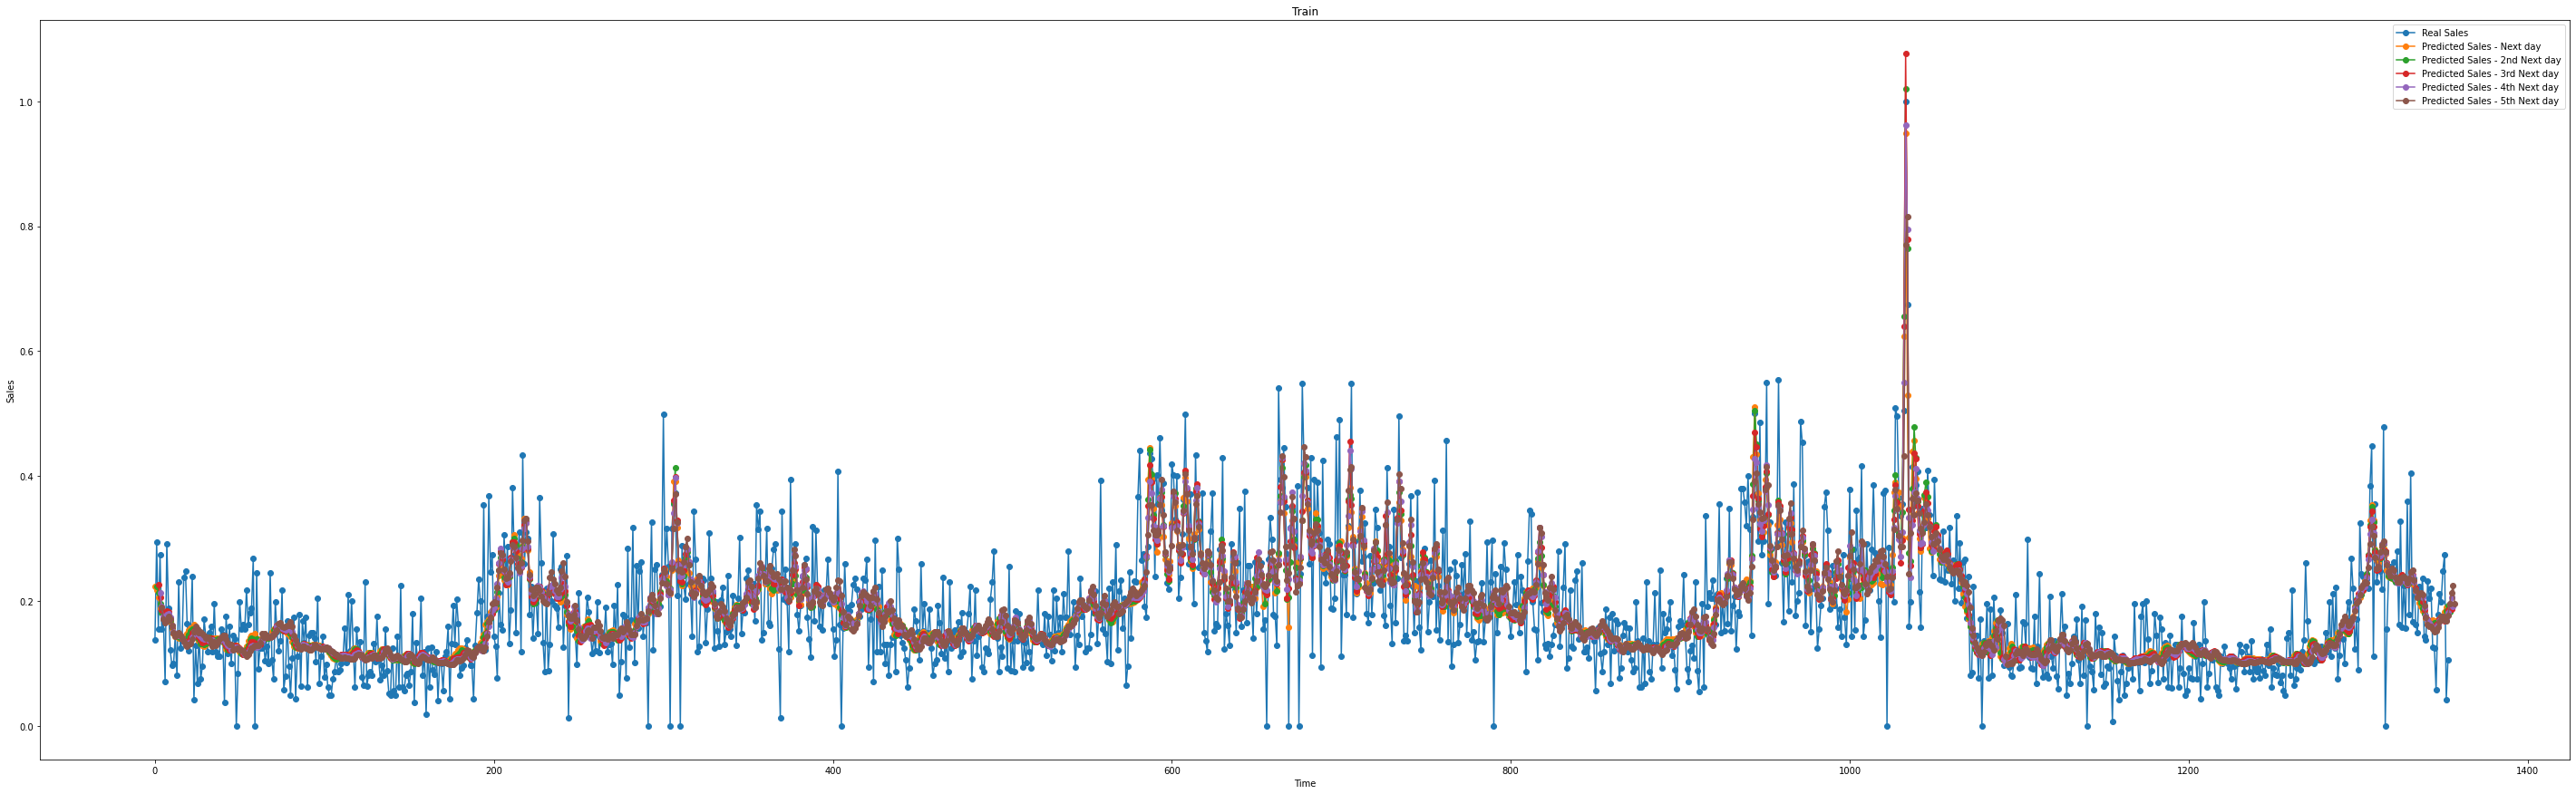

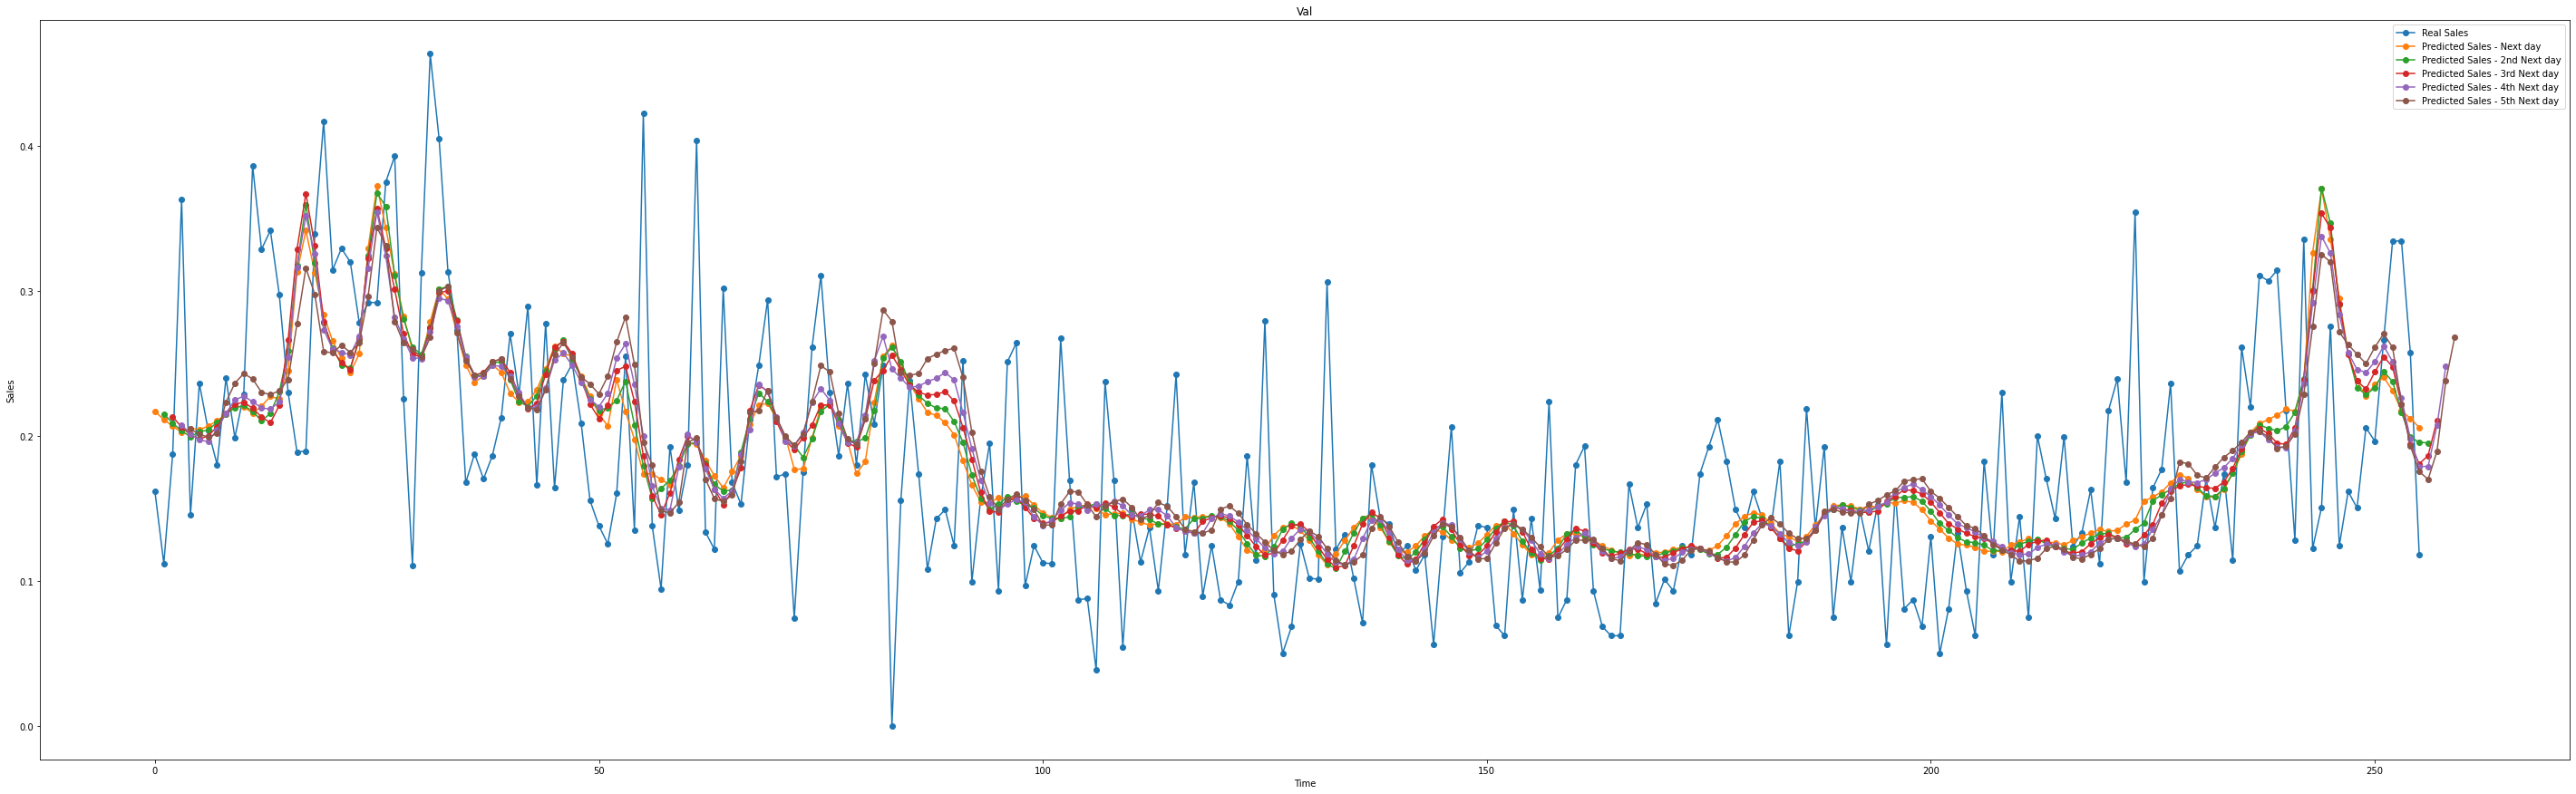

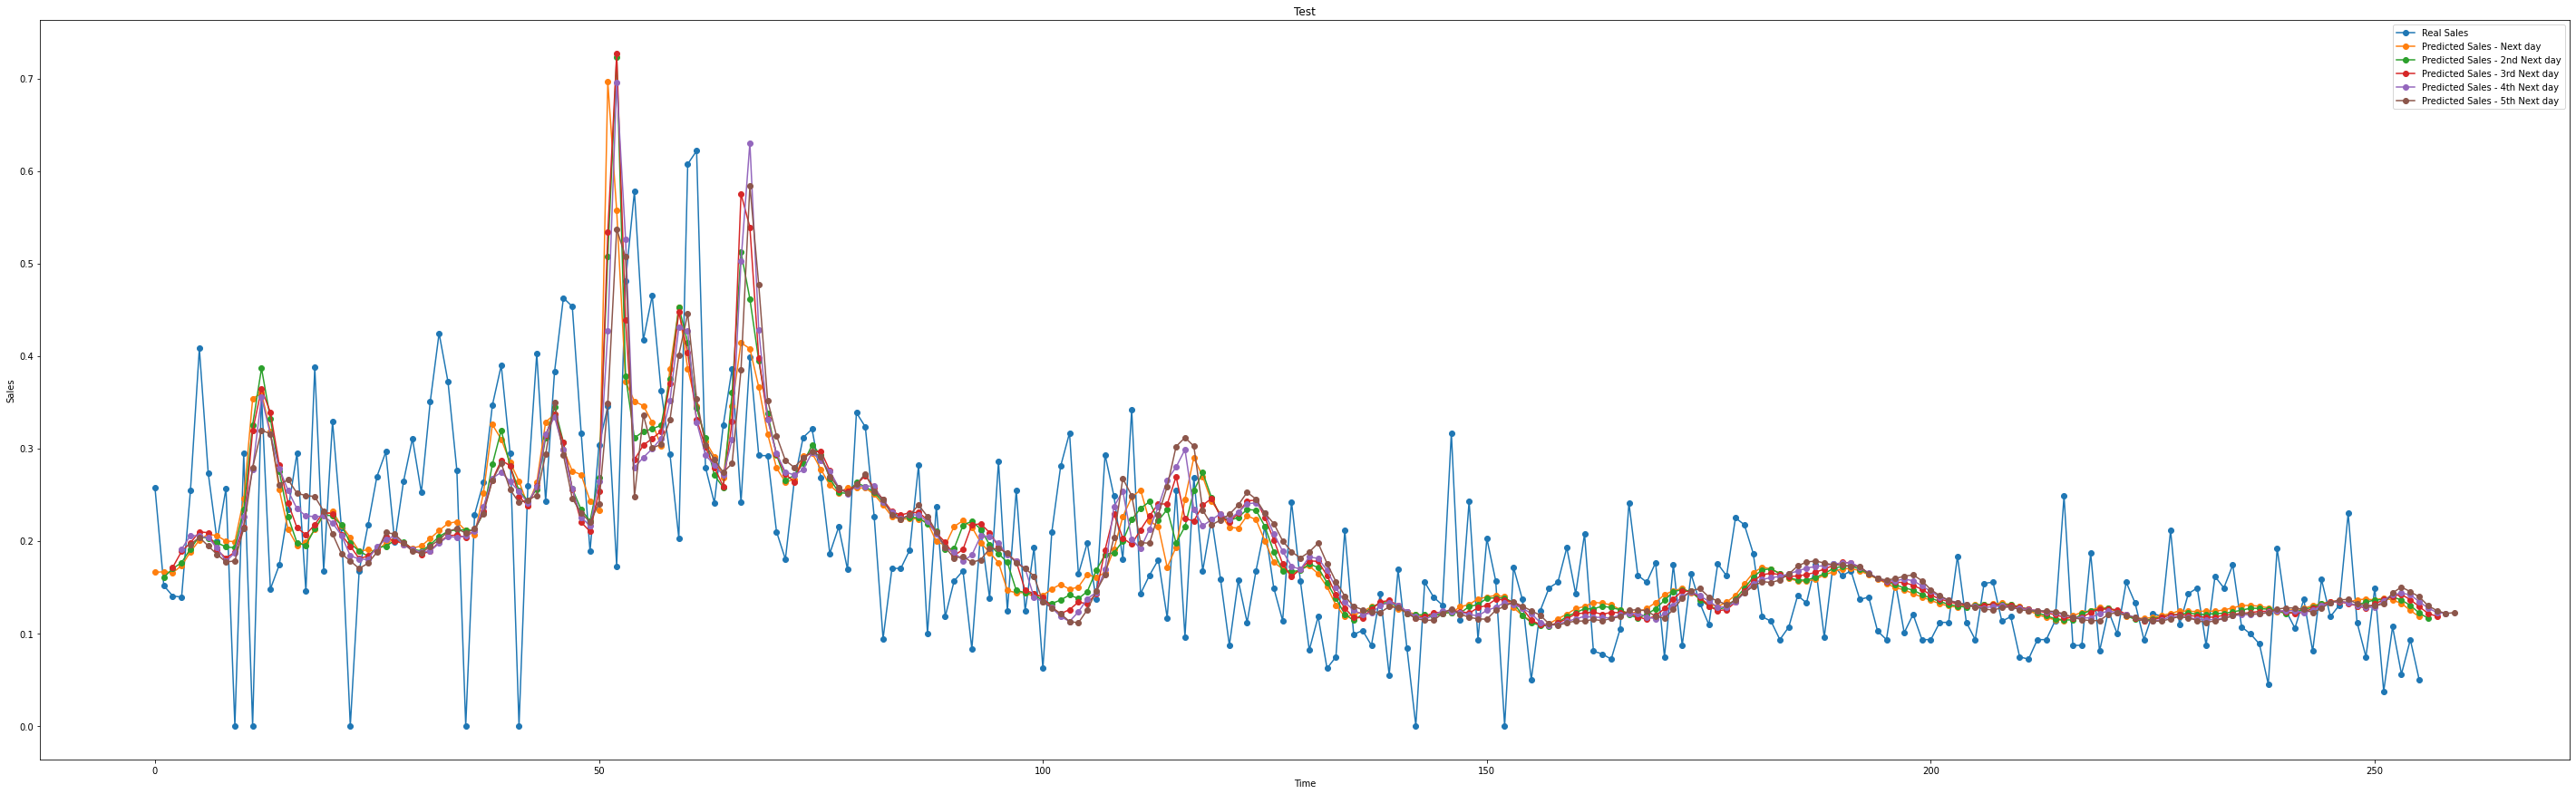

In [0]:
y_train_predict = regressor.predict(x_train)
y_val_predict = regressor.predict(x_val)
y_test_predict = regressor.predict(x_test)

plt.figure(figsize=(50,15))
plt.plot(y_train[:,0],marker='o',label='Real Sales')
plt.plot(y_train_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_train_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_train_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_train_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_train_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Train')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_val[:,0],marker='o',label='Real Sales')
plt.plot(y_val_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_val_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_val_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_val_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_val_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Val')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

plt.figure(figsize=(50,15))
plt.plot(y_test[:,0],marker='o',label='Real Sales')
plt.plot(y_test_predict[:,0],marker='o',label='Predicted Sales - Next day')
plt.plot(np.concatenate(([None],y_test_predict[:, 1])),marker='o',label='Predicted Sales - 2nd Next day')
plt.plot(np.concatenate(([None, None],y_test_predict[:, 2])),marker='o',label='Predicted Sales - 3rd Next day')
plt.plot(np.concatenate(([None, None, None],y_test_predict[:, 3])),marker='o',label='Predicted Sales - 4th Next day')
plt.plot(np.concatenate(([None, None, None,None],y_test_predict[:, 4])),marker='o',label='Predicted Sales - 5th Next day')
plt.title('Test')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()